In [61]:
import pandas as pd
import numpy as np
import os
import torch
import torchtext
from torchtext import data
import torch.optim as optim
import argparse
import os
import pandas as pd
import torch.nn as nn
from torchmetrics.classification import MulticlassAccuracy

### Importing the dataset

In [41]:
df = pd.read_csv('Dataset/ToS-100-cleaned.csv',header=0,encoding='utf-8')
data = df[['text','label']]
data

,text,label
0,websites & communications terms of use,0
1,please read the terms of this entire document ...,0
2,by accessing or signing up to receive communic...,4
3,our websites include multiple domains such as ...,0
4,you may also recognize our websites by nicknam...,0
...,...,...
20412,you may terminate your account at our service ...,0
20413,the following provisions shall survive termina...,0
20414,"the company reserves the right , at its sole d...",3
20415,"your continued use of the service , following ...",4


## Reading the dataset

In [27]:
text = data['text'].values.tolist()
labels = data['label'].values.tolist()

#### HyperParameter

In [15]:
embd_size = 64

## Tokenization and Embedding

In [21]:
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize
import nltk

nltk.download('punkt')

# Tokenize the sentences
tokenized_sentences = [word_tokenize(tos.lower()) for tos in text]

# Train the Word2Vec model
embedding = Word2Vec(sentences=tokenized_sentences, vector_size=embd_size, window=5, min_count=1, workers=4)

# Save the model
if not os.path.exists("Model/baseline"):
    os.makedirs("Model/baseline")
embedding.save("Model/baseline/word2vec_model_tos")

# Access word embeddings
word_embeddings = embedding.wv
tos_embeddings = [[word_embeddings[word] for word in tos] for tos in tokenized_sentences]

[nltk_data] Downloading package punkt to /Users/joeliang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


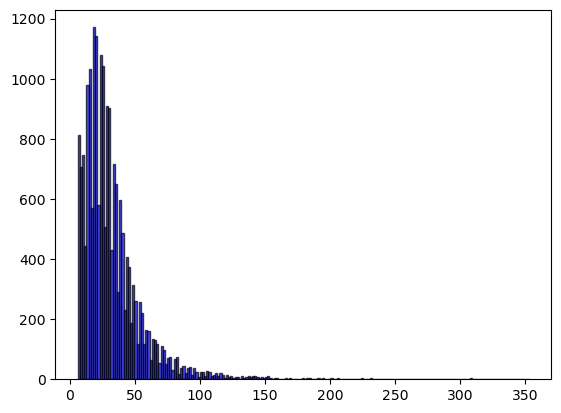

number of sentences longer than 128: 212


In [18]:
import matplotlib.pyplot as plt

# collect the length of sentences
# used to decide on a practical sequence_length for training
length_data = [len(tos) for tos in tokenized_sentences]

plt.hist(length_data, bins='auto', alpha=0.7, color='blue', edgecolor='black')
plt.show()

# no of sentences longer than threshold
threshold = 128
print(f"number of sentences longer than {threshold}: {len([l for l in length_data if l > threshold])}")


## Clean the dataset

* Crop sentences longer than seq_length.
* Add padding to the beginning of other sentences.
* Fix the class imbalance between fair and unfair sentences.

In [29]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import torch
max_length = 128
def crop_and_pad(sentence, seq_length=max_length):
    length = len(sentence)

    if length > seq_length:
        new_sentence = sentence[:seq_length]
    else:
        new_sentence = [np.zeros(embd_size)]*(seq_length - length) + sentence

    return new_sentence

# crop and pad
processed_embeddings = np.stack([crop_and_pad(tos) for tos in tos_embeddings], axis = 0)

# class balancing
smote = SMOTE(sampling_strategy='auto', random_state=42)

indices = [[i] for i in range(len(labels))] # smote requires 2-D array!

indices, labels = smote.fit_resample(indices, labels) # smote cannot work on text data, so passing indices

processed_embeddings = [torch.tensor(processed_embeddings[i[0]], dtype=torch.float32) for i in indices]
labels = torch.tensor(labels, dtype=torch.float32)

After SMOTE sampling
number of fair sentences: 18235
number of unfair sentences: 18235


In [30]:
# make sure class balance is achieved
print("After SMOTE sampling")
print(f"class 0: {len([label for label in labels if label == 0])}")
print(f"class 1: {len([label for label in labels if label == 1])}")
print(f"class 2: {len([label for label in labels if label == 2])}")
print(f"class 3: {len([label for label in labels if label == 3])}")
print(f"class 4: {len([label for label in labels if label == 4])}")


dataset = list(zip(processed_embeddings, labels))

# Split the data into training and testing sets
train_dataset, test_dataset = train_test_split(dataset, test_size=0.1, random_state=42)

After SMOTE sampling
class 0: 18235
class 1: 18235
class 2: 18235
class 3: 18235
class 4: 18235


## Classification_model

In [32]:
from torch.utils.data import DataLoader
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [50]:
from datasets import load_from_disk
dataset = load_from_disk(dataset_path='Dataset/ToS-100-cleaned-dataset-huggingface')
train = pd.DataFrame(dataset['train'])
test = pd.DataFrame(dataset['test'])
train, validate = train_test_split(train, test_size=0.2, random_state=42)

In [104]:
def get_target(y_batch,device):
    target = np.zeros((len(y_batch), 5))
    index = 0
    for y in y_batch:
        target[index][y] = 1
        index += 1
        target = torch.tensor(target).to(torch.float).to(device)
    return target

In [52]:
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, vocab, df):
        # X: torch.tensor (maxlen, batch_size), padded indices
        # Y: torch.tensor of len N
        X, Y = [], []
        V = len(vocab.vectors)
        for i, row in df.iterrows():
            L = row["text"].split()
            X.append(torch.tensor([vocab.stoi.get(w, V-1) for w in L]))  # Use the last word in the vocab as the "out-of-vocabulary" token
            Y.append(row.label)
        self.X = X
        self.Y = torch.tensor(Y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]
    
def my_collate_function(batch, device):
    # Handle the padding here
    # batch is approximately: [dataset[i] for i in range(0, batch_size)]
    # Since the dataset[i]'s contents is defined in the __getitem__() above, this collate function
    # should be set correspondingly.
    # Also: collate_function just takes one argument. To pass in additional arguments (e.g., device),
    # we need to wrap up an anonymous function (using lambda below)
    batch_x, batch_y = [], []
    max_len = 0
    for x,y in batch:
        batch_y.append(y)
        max_len = max(max_len, len(x))
    for x,y in batch:
        x_p = torch.concat(
            [x, torch.zeros(max_len - len(x))]
        )
        batch_x.append(x_p)
    return torch.stack(batch_x).t().int().to(device), torch.tensor(batch_y).to(device)

In [107]:
def main(args):
    #   fix seed
    torch.manual_seed(2)

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print ("Using device:", device)

    glove = torchtext.vocab.GloVe(name="6B",dim=100)

    train_dataset = TextDataset(glove, train)
    val_dataset = TextDataset(glove, validate)

    train_dataloader = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    validation_dataloader = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=args.batch_size,
        shuffle=False,
        collate_fn=lambda batch: my_collate_function(batch, device))

    # Instantiate your model(s) and train them and so on
    # We suggest parameterizing the model - k1, n1, k2, n2, and other hyperparameters
    # so that it is easier to experiment with

    class CNN(nn.Module):
      def __init__(self, embedding_dim, k1, k2, n1, n2):
          super(CNN, self).__init__()

          self.embedding = nn.Embedding.from_pretrained(glove.vectors)
          self.layer1 = nn.Conv2d(1,n1,kernel_size=(k1,embedding_dim),bias = False)
          self.activition = torch.nn.ReLU()

          self.layer2 = nn.Conv2d(1,n2,kernel_size=(k2,embedding_dim),bias = False)
          self.linear = torch.nn.Linear(in_features=n1+n2,out_features= 5)

      def forward(self, x):
        x = self.embedding(x).permute(1, 0, 2)
        x = torch.unsqueeze(x, 1)

        x1 = self.layer1(x)
        x1  = self.activition(x1).squeeze(3)
        x1 = nn.functional.max_pool1d(x1, x1.size(2)).squeeze(2)

        x2 = self.layer2(x)
        x2 = self.activition(x2).squeeze(3)
        x2 = nn.functional.max_pool1d(x2, x2.size(2)).squeeze(2)
        x  = torch.cat((x1,x2),1)

        logits = self.linear(x)

        return logits

    def train_cnn(lr_rate,epochs, k1, k2, n1, n2):
      network = CNN(100, k1, k2, n1, n2).to(device)
      criterion = nn.CrossEntropyLoss().to(device)
      optimizer = torch.optim.Adam(network.parameters(),lr = lr_rate)
      metric = MulticlassAccuracy(num_classes=5).to(device)

      trainepoch_loss = []
      valepoch_loss = []
      trainepoch_accurcy = []
      valepoch_accurcy = []

        # validation dataset
      def evaluation(network):
          valid_loss = []
          valid_accuracy = []
          for i, (X_batch, y_batch) in enumerate(validation_dataloader):
            X_batch.to(device)
            target = get_target(y_batch,device)
            output = network(X_batch)
            loss_val = criterion(output,target.squeeze(1))
            # loss and accuracy
            probs = torch.sigmoid(output)
            valid_accuracy.append(metric(probs, target).item())
            valid_loss.append(loss_val.item())
          return valid_accuracy,valid_loss

      for epoch in range(epochs):
          train_loss = []
          train_accuracy = []

          for i, (X_batch, y_batch) in enumerate(train_dataloader):
            target = get_target(y_batch,device)


            optimizer.zero_grad()

            output = network(X_batch)
            loss = criterion(output,target)
            loss.backward()
            optimizer.step()

            # loss and accuracy
            train_loss.append(loss.item())

            probs = torch.sigmoid(output)
            train_accuracy.append(metric(probs, target).item())

          # running evaluation function once per two epoch
          if (epoch % 2 == 0):
            valid_accuracy,valid_loss = evaluation(network)


          print(f'\t\t ------- Epoch {epoch+1} ---------')
          print(f'\t\t Training Loss: {np.mean(train_loss)} \t\t Training Accurcy: {np.mean(train_accuracy)}')
          print(f'\t\t Validation Loss: {np.mean(valid_loss)} \t\t Validation Accurcy: {np.mean(valid_accuracy)}')

          trainepoch_loss.append(np.mean(train_loss))
          valepoch_loss.append(np.mean(valid_loss))

          trainepoch_accurcy.append(np.mean(train_accuracy))
          valepoch_accurcy.append(np.mean(valid_accuracy))

      return trainepoch_loss,trainepoch_accurcy,valepoch_loss,valepoch_accurcy,network

    trainepoch_loss,trainepoch_accurcy,valepoch_loss,valepoch_accurcy,network = train_cnn(0.003,40,args.k1,args.k2,args.n1,args.n2)
    return trainepoch_loss,trainepoch_accurcy,valepoch_loss,valepoch_accurcy,network

In [112]:
np.random.seed(43)
torch.manual_seed(43)

# different combinations
batch_size = [10]
k = [[2,4]]
n = [60]

#through each hyperparameter
for batch in batch_size:
  for k1,k2 in k:
    for n_size in n:
      print('===' + str(batch) + '===' + str(k1) + '===' + str(k2) + '===' + str(n_size))
      trainepoch_loss,trainepoch_accurcy,valepoch_loss,valepoch_accurcy,network = main(
          args=argparse.Namespace(batch_size=batch,overfit = False,k1 = k1,k2 = k2,n1=n_size,n2=n_size))

===10===2===4===60
Using device: cpu


/var/folders/v4/nb6fv1kd5zjc4dx7n_vnd8mr0000gn/T/ipykernel_70595/2189369551.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target = torch.tensor(target).to(torch.float).to(device)


		 ------- Epoch 1 ---------
		 Training Loss: 0.4128002048292115 		 Training Accurcy: 0.5
		 Validation Loss: 0.21851379037451968 		 Validation Accurcy: 0.5
		 ------- Epoch 2 ---------
		 Training Loss: 0.1578863416119074 		 Training Accurcy: 0.5
		 Validation Loss: 0.21851379037451968 		 Validation Accurcy: 0.5
		 ------- Epoch 3 ---------
		 Training Loss: 0.08868737553442639 		 Training Accurcy: 0.5
		 Validation Loss: 0.09174735820373801 		 Validation Accurcy: 0.5
		 ------- Epoch 4 ---------
		 Training Loss: 0.05884459543059043 		 Training Accurcy: 0.5000214224558359
		 Validation Loss: 0.09174735820373801 		 Validation Accurcy: 0.5
		 ------- Epoch 5 ---------
		 Training Loss: 0.04560560678465026 		 Training Accurcy: 0.5002142245583587
		 Validation Loss: 0.15065409811090022 		 Validation Accurcy: 0.5003424658350748
		 ------- Epoch 6 ---------
		 Training Loss: 0.03520272093663381 		 Training Accurcy: 0.5015852617063171
		 Validation Loss: 0.15065409811090022 		 Validation A

In [ ]:
test_accuracy = []
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
metric = MulticlassAccuracy(num_classes=5).to(device)

glove = torchtext.vocab.GloVe(name="6B",dim=100)

test_dataset = TextDataset(glove, "test")

test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset,batch_size=5,
    shuffle=False,
    collate_fn=lambda batch: my_collate_function(batch, device))


for i, (X_batch, y_batch) in enumerate(test_dataloader):
  target = torch.tensor([[y] for y in y_batch]).to(torch.float).to(device)
  X_batch.to(device)
  output = network(X_batch)
  probs = torch.sigmoid(output)
  test_accuracy.append(metric(probs, target).item())
  
print('the final test accuracy is: ' + str(np.mean(test_accuracy)))